# Download the cityscapes dataset 

In [4]:
import requests
from PIL import Image

dowload_images = False

if dowload_images:
    total_images = 450
    base_url_input = 'https://phillipi.github.io/pix2pix/images/cityscapes_L1_BtoA/latest_net_G_val/images/input/'
    base_url_target = 'https://phillipi.github.io/pix2pix/images/cityscapes_L1_BtoA/latest_net_G_val/images/target/'
    for i in range(total_images):
        url_input = base_url_input + f'{i}.jpg'
        url_target = base_url_target + f'{i}.jpg'
        data_input = requests.get(url_input).content 
        data_target = requests.get(url_target).content 
        f = open(f'./images/input{i}.jpg','wb') 
        f.write(data_input) 
        f.close() 
        f = open(f'./images/target{i}.jpg','wb') 
        f.write(data_target) 
        f.close() 


# Plot Randomly Picked Data Point

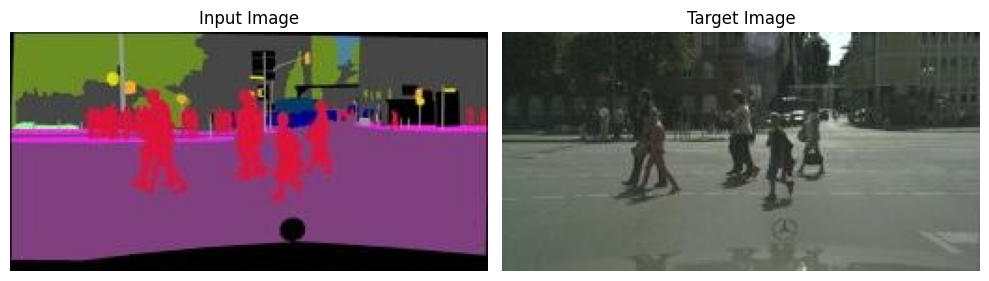

In [5]:
import os
import random
import matplotlib.pyplot as plt

images_dir = f'./index_cityscapes/'

images_list = os.listdir(images_dir)

input_list = [i for i in images_list if 'input' in i]
target_list = [i for i in images_list if 'target' in i]

# Get a random index
random_index = random.randint(0, len(input_list) - 1)

# Get the item at the random index
random_input = input_list[random_index]
random_target = target_list[random_index]

chosen_input = Image.open(images_dir+random_input)
chosen_target = Image.open(images_dir+random_target)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image
axes[0].imshow(chosen_input, cmap='viridis')
axes[0].set_title("Input Image")
axes[0].axis('off')  # Hide axes

# Plot the second image
axes[1].imshow(chosen_target, cmap='plasma')
axes[1].set_title("Target Image")
axes[1].axis('off')  # Hide axes

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Create a DataLoader with Input and Target

In [6]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class PairedImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        """
        Args:
            folder (str): Directory containing both input and target images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.folder = folder
        self.input_files = sorted([f for f in os.listdir(folder) if f.startswith('input') and f.endswith(('.png', '.jpg', '.jpeg'))])
        self.target_files = sorted([f for f in os.listdir(folder) if f.startswith('target') and f.endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform

        assert len(self.input_files) == len(self.target_files), "Mismatch in the number of input and target images!"

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # Get paths for input and target images
        input_path = os.path.join(self.folder, self.input_files[idx])
        target_path = os.path.join(self.folder, self.target_files[idx])

        # Load images
        input_image = Image.open(input_path)
        target_image = Image.open(target_path)

        # Apply transformations
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# Directory containing images
image_folder = r"./index_cityscapes/"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),          # Convert to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Initialize the dataset
dataset = PairedImageDataset(folder=image_folder, transform=transform)

# Split into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterate over the train loader
for input_images, target_images in train_loader:
    print(f"Input batch shape: {input_images.shape}")
    print(f"Target batch shape: {target_images.shape}")
    break


Input batch shape: torch.Size([8, 3, 256, 256])
Target batch shape: torch.Size([8, 3, 256, 256])


# Building the Pix2Pix GAN Network

In [7]:
import torch
import torch.nn as nn

## U-Net Architecture - Generator

In [8]:
class UpConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz, dropout=0.0):
        super(UpConvBlock, self).__init__()
        self.layers = [
            nn.ConvTranspose2d(ip_sz, op_sz, 4, 2, 1),
            nn.InstanceNorm2d(op_sz),
            nn.ReLU(),
        ]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
        
        self.layers = nn.Sequential(*(self.layers))

    def forward(self, x, enc_ip):
        x = self.layers(x)
        op = torch.cat((x, enc_ip), 1)
        return op

class DownConvBlock(nn.Module):
    
    def __init__(self, ip_sz, op_sz, norm=True, dropout=0.0):
        super(DownConvBlock, self).__init__()
        self.layers = [nn.Conv2d(ip_sz, op_sz, 4, 2, 1)]
        if norm:
            self.layers.append(nn.InstanceNorm2d(op_sz))
        self.layers += [nn.LeakyReLU(0.2)]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
        self.layers = nn.Sequential(*(self.layers))

    def forward(self, x):
        op = self.layers(x)
        return op

class UNetGenerator(nn.Module):

    def __init__(self, chnls_in=3, chnls_op=3):
        super(UNetGenerator, self).__init__()
        self.down_conv_layer_1 = DownConvBlock(chnls_in, 64, norm=False)
        self.down_conv_layer_2 = DownConvBlock(64, 128)
        self.down_conv_layer_3 = DownConvBlock(128, 256)
        self.down_conv_layer_4 = DownConvBlock(256, 512, dropout=0.5)
        self.down_conv_layer_5 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer_6 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer_7 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer_8 = DownConvBlock(512, 512, norm=False, dropout=0.5)
        self.up_conv_layer_1 = UpConvBlock(512, 512, dropout=0.5)
        self.up_conv_layer_2 = UpConvBlock(1024, 512, dropout=0.5)
        self.up_conv_layer_3 = UpConvBlock(1024, 512, dropout=0.5)
        self.up_conv_layer_4 = UpConvBlock(1024, 512, dropout=0.5)
        self.up_conv_layer_5 = UpConvBlock(1024, 256)
        self.up_conv_layer_6 = UpConvBlock(512, 128)
        self.up_conv_layer_7 = UpConvBlock(256, 64)
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_1 = nn.Conv2d(128, chnls_op, 4, padding=1)
        self.activation = nn.Tanh()

    def forward(self, x):
        enc1 = self.down_conv_layer_1(x)
        enc2 = self.down_conv_layer_2(enc1)
        enc3 = self.down_conv_layer_3(enc2)
        enc4 = self.down_conv_layer_4(enc3)
        enc5 = self.down_conv_layer_5(enc4)
        enc6 = self.down_conv_layer_6(enc5)
        enc7 = self.down_conv_layer_7(enc6)
        enc8 = self.down_conv_layer_8(enc7)
        dec1 = self.up_conv_layer_1(enc8, enc7)
        dec2 = self.up_conv_layer_2(dec1, enc6)
        dec3 = self.up_conv_layer_3(dec2, enc5)
        dec4 = self.up_conv_layer_4(dec3, enc4)
        dec5 = self.up_conv_layer_5(dec4, enc3)
        dec6 = self.up_conv_layer_6(dec5, enc2)
        dec7 = self.up_conv_layer_7(dec6, enc1)
        final = self.upsample_layer(dec7)
        final = self.zero_pad(final)
        final = self.conv_layer_1(final)
        return self.activation(final)

In [9]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_generator = UNetGenerator(chnls_in=3, chnls_op=3).to(device)


In [10]:
summary(model_generator,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
     DownConvBlock-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
     DownConvBlock-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
    DownConvBlock-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,664
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
        LeakyReLU-14          [-1, 512,

In [11]:
class Pix2PixDiscriminator(nn.Module):
    def __init__(self, chnls_in=3):
        super(Pix2PixDiscriminator, self).__init__()
        def disc_conv_block(chnls_in, chnls_op, norm=1):
            layers = [nn.Conv2d(chnls_in, chnls_op, 4, stride=2, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(chnls_op))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        self.lyr1 = disc_conv_block(chnls_in * 2, 64, norm=0)
        self.lyr2 = disc_conv_block(64, 128)
        self.lyr3 = disc_conv_block(128, 256)
        self.lyr4 = disc_conv_block(256, 512)
        self.dropout = nn.Dropout2d(0.2)
        self.padlayr = nn.ZeroPad2d((1, 0, 1, 0))
        self.convlayer1 = nn.Conv2d(512, 1, 4, padding=1)
        #self.fltlayr = nn.Flatten()
        #self.linlayer = nn.Linear(256,1)

        
    def forward(self, real_image, translated_image):
        ip = torch.cat((real_image, translated_image), 1)
        op = self.lyr1(ip)
        op = self.lyr2(op)
        op = self.lyr3(op)
        op = self.lyr4(op)
        op = self.padlayr(op)
        op = self.convlayer1(op)
        #op = self.fltlayr(op)
        #op = self.linlayer(torch.flatten(op, start_dim=1))

        return op

In [12]:
model_discriminator = Pix2PixDiscriminator(chnls_in=3)
model_discriminator

Pix2PixDiscriminator(
  (lyr1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (lyr2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (lyr3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (lyr4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dropout): Dropout2d(p=0.2, inplace=False)
  (padlayr): ZeroPad2d((1, 0

In [13]:
import torch

# Create dummy data (real and fake images)
batch_size = 2
real_image = torch.randn(batch_size, 3, 256, 256)  # Example real image
translated_image = torch.randn(batch_size, 3, 256, 256)  # Example fake image

# Check if CUDA is available, and move both the model and inputs to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move to the selected device
model_discriminator = Pix2PixDiscriminator(chnls_in=3).to(device)

# Move the input tensors to the same device (GPU or CPU)
real_image = real_image.to(device)
translated_image = translated_image.to(device)

# Perform a forward pass
output_real = model_discriminator(real_image, translated_image)

# Check the output
print(f"Discriminator output shape: {output_real.shape}")

# Ensure the output is a batch of probabilities (sigmoid output expected)
if output_real.shape == (batch_size, 1, 32, 64):  # Example output shape (adjust based on your model)
    print("Discriminator output is valid.")
else:
    print("Discriminator output shape is invalid.")


Discriminator output shape: torch.Size([2, 1, 16, 16])
Discriminator output shape is invalid.


## Creating GAN Model and Training Loop

In [14]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
import numpy as np

In [15]:
# Define the loss functions
criterion_GAN = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss for GAN
criterion_L1 = nn.L1Loss()  # L1 loss for pixel-wise consistency

In [16]:
def plot_losses(G_losses, D_losses, epoch):
    plt.figure()
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Losses at Epoch {epoch+1}")
    plt.savefig(f"loss_epoch_{epoch+1}.png")
    plt.close()

def save_generated_image(fake_image, target_image, epoch, save_dir="output_images"):
    fake_image = fake_image[0].cpu().detach().squeeze().permute(1, 2, 0).numpy()
    target_image = target_image[0].cpu().detach().squeeze().permute(1, 2, 0).numpy()

    # Rescale images from [-1, 1] to [0, 1] (common in GANs)
    fake_image = (fake_image + 1) / 2.0
    target_image = (target_image + 1) / 2.0

    # Clip to ensure values are within [0, 1]
    fake_image = np.clip(fake_image, 0, 1)
    target_image = np.clip(target_image, 0, 1)

    # Save the generated image and target image for comparison
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(fake_image)
    plt.title("Generated Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(target_image)
    plt.title("Target Image")
    plt.axis('off')

    plt.savefig(f"./{save_dir}/generated_epoch_{epoch+1}.png")
    plt.close()


In [17]:
# Training Loop
def train_pix2pix(generator, discriminator, dataloader, num_epochs=10, device='cuda', save_interval = 50):
    
    generator.to(device)
    discriminator.to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Losses for each epoch
    G_losses = []
    D_losses = []
    
    # Validation Image (to track the same image throughout epochs)
    val_image = next(iter(dataloader))  # Get one batch of images for visualization
    val_input, val_target = val_image
    val_input, val_target = val_input.to(device), val_target.to(device)

    for epoch in range(num_epochs):
        G_loss_epoch = 0
        D_loss_epoch = 0
        
        # Train on entire dataset
        for i, (input_image, target_image) in enumerate(dataloader):
            input_image, target_image = input_image.to(device), target_image.to(device)

            # -------------------
            #  Train Discriminator
            # -------------------

            optimizer_D.zero_grad()

            # Real images
            real_labels = torch.ones(input_image.size(0), *(16,16)).to(device)
            real_pred = discriminator(input_image, target_image)
            loss_D_real = criterion_GAN(real_pred.squeeze(), real_labels)

            # Fake images (generated by the generator)
            fake_images = generator(input_image)
            fake_labels = torch.zeros(input_image.size(0), *(16,16)).to(device)
            fake_pred = discriminator(input_image, fake_images.detach())  # Don't compute gradients for fake images
            loss_D_fake = criterion_GAN(fake_pred.squeeze(), fake_labels)

            # Total loss for Discriminator
            loss_D = (loss_D_real + loss_D_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            # -------------------
            #  Train Generator
            # -------------------

            optimizer_G.zero_grad()

            # Adversarial loss for the generator
            fake_pred = discriminator(input_image, fake_images)
            loss_GAN = criterion_GAN(fake_pred.squeeze(), real_labels)

            # Pixel-wise L1 loss for the generator
            loss_L1 = criterion_L1(fake_images, target_image)

            # Total loss for Generator
            loss_G = loss_GAN + 100 * loss_L1  # 100 is a commonly used weight for L1 loss
            loss_G.backward()
            optimizer_G.step()

            G_loss_epoch += loss_G.item()
            D_loss_epoch += loss_D.item()

        # Average the losses for the epoch
        G_losses.append(G_loss_epoch / len(dataloader))
        D_losses.append(D_loss_epoch / len(dataloader))

        # Plot Losses
        if epoch%(save_interval) == 0:
            plot_losses(G_losses, D_losses, epoch)

            # Save generated image at every epoch (same validation image)
            with torch.no_grad():
                val_fake_image = generator(val_input)
                save_generated_image(val_fake_image, val_target, epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Generator Loss: {G_losses[-1]:.4f} | Discriminator Loss: {D_losses[-1]:.4f}")
        
    return generator, discriminator



In [18]:
# Initialize the model and dataloader (assuming you have the paired dataset loaded in `train_loader`)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize generator and discriminator
generator = UNetGenerator(chnls_in=3, chnls_op=3)  # Adjust channels if needed
discriminator = Pix2PixDiscriminator(chnls_in=3)  # Assuming PatchGANDiscriminator is defined

# Train the model
train_pix2pix(generator, discriminator, train_loader, num_epochs=500, device=device)

Epoch [1/500] | Generator Loss: 24.9764 | Discriminator Loss: 0.5615
Epoch [2/500] | Generator Loss: 23.1706 | Discriminator Loss: 0.3623
Epoch [3/500] | Generator Loss: 23.0352 | Discriminator Loss: 0.3446
Epoch [4/500] | Generator Loss: 23.2674 | Discriminator Loss: 0.3320
Epoch [5/500] | Generator Loss: 23.0739 | Discriminator Loss: 0.3302
Epoch [6/500] | Generator Loss: 22.9006 | Discriminator Loss: 0.3607
Epoch [7/500] | Generator Loss: 22.8267 | Discriminator Loss: 0.3440
Epoch [8/500] | Generator Loss: 22.7374 | Discriminator Loss: 0.3681
Epoch [9/500] | Generator Loss: 22.7741 | Discriminator Loss: 0.3504
Epoch [10/500] | Generator Loss: 22.4375 | Discriminator Loss: 0.3610
Epoch [11/500] | Generator Loss: 22.2428 | Discriminator Loss: 0.3879
Epoch [12/500] | Generator Loss: 21.9535 | Discriminator Loss: 0.3790
Epoch [13/500] | Generator Loss: 21.6800 | Discriminator Loss: 0.3773
Epoch [14/500] | Generator Loss: 21.1477 | Discriminator Loss: 0.3987
Epoch [15/500] | Generator Lo

(UNetGenerator(
   (down_conv_layer_1): DownConvBlock(
     (layers): Sequential(
       (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
       (1): LeakyReLU(negative_slope=0.2)
     )
   )
   (down_conv_layer_2): DownConvBlock(
     (layers): Sequential(
       (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
       (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (2): LeakyReLU(negative_slope=0.2)
     )
   )
   (down_conv_layer_3): DownConvBlock(
     (layers): Sequential(
       (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
       (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       (2): LeakyReLU(negative_slope=0.2)
     )
   )
   (down_conv_layer_4): DownConvBlock(
     (layers): Sequential(
       (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
       (1): InstanceNorm2d(512, eps=1e-05, mom

# Saving The Generator and Discriminator Model

In [19]:
import torch

# Assuming `model` is your PyTorch model
torch.save(generator.state_dict(), "model_generator.pth")
torch.save(discriminator.state_dict(), "model_discriminator.pth")
print("Model saved successfully!")


Model saved successfully!


In [20]:
# Assuming `MyModel` is the class of your model
model = UNetGenerator()  # Recreate the architecture
model.load_state_dict(torch.load("model_generator.pth"))
model.eval()  # Set the model to evaluation mode (optional)
print("Model loaded successfully!")


/tmp/ipykernel_4289/1457167901.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_generatorV2.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'model_generatorV2.pth'

In [36]:
test_iter = iter(test_loader)
test_example = next(test_iter)

## Predict on a Test Dataset

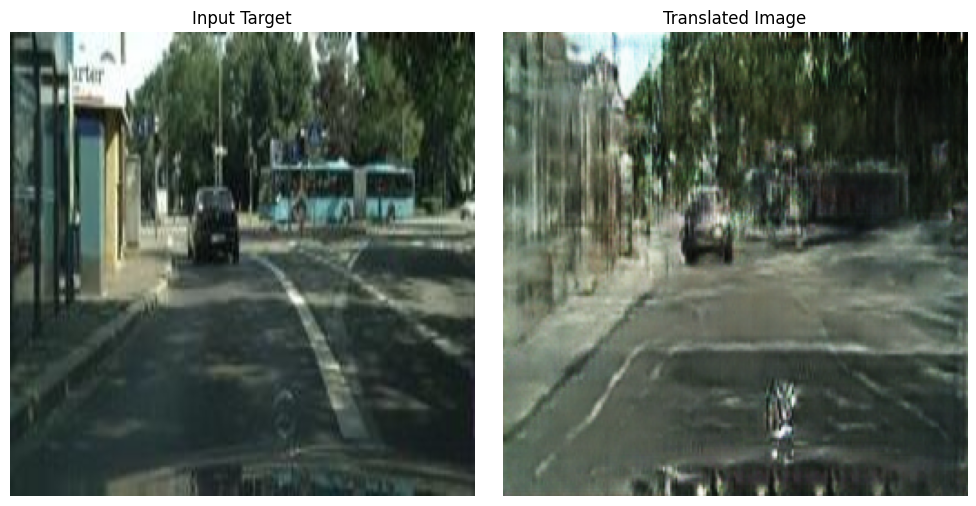

In [54]:
input_test = test_example[0][0].cpu().detach().squeeze().permute(1, 2, 0).numpy()
input_target = test_example[1][0].cpu().detach().squeeze().permute(1, 2, 0).numpy()

pred_image = model(test_example[0][0].unsqueeze(dim=0))
pred_image = pred_image.cpu().detach().squeeze().permute(1, 2, 0).numpy()

# Rescale images from [-1, 1] to [0, 1] (common in GANs)
input_test = (input_test + 1) / 2.0
pred_test = (pred_image + 1) / 2.0
input_target = (input_target + 1) / 2.0

# Clip to ensure values are within [0, 1]
input_test = np.clip(input_test, 0, 1)
pred_image = np.clip(pred_test, 0, 1)
input_target = np.clip(input_target, 0, 1)


# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image
axes[0].imshow(input_target, cmap='viridis')
axes[0].set_title("Input Target")
axes[0].axis('off')  # Hide axes

# Plot the second image
axes[1].imshow(pred_image, cmap='plasma')
axes[1].set_title("Translated Image")
axes[1].axis('off')  # Hide axes

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()